<a id='top'></a><a name='top'></a>
# Chapter 5: Baby steps with neural networks (perceptrons and backpropagation)

* [Introduction](#introduction)
* [5.0 Imports and Setup](#5.0)
* [5.1 Neural Networks](#5.1)
     - [5.1.1 Perceptron](#5.1.1)
     - [5.1.2 A numerical perceptron](#5.1.2)
     - [5.1.3 Detour through bias](#5.1.3)
     - [5.1.4 Let's go skiing - the error surface](#5.1.4)
     - [5.1.5 Off the chair lift, onto the slope](#5.1.5)
     - [5.1.6 Let's shake things up a bit](#5.1.6)
     - [5.1.7 Keras: Neural networks in Python](#5.1.7)
     - [5.1.8 Onward and deepward](#5.1.8)
     - [5.1.9 Normalization: input with style](#5.1.9)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* No datasets

### Explore

* Learning the history of neural networks
* Stacking perceptrons
* Understanding backpropagation
* Seeing the knobs to turn on neural networks
* Implementing a basic neural network in Keras


### Key points

* Minimizing a cost function is a path toward learning
* A backpropagation algorithm is the means by which a network learns.
* The amount a weight contributes to a model's error is directly related to the amount it needs to be updated.
* Neural networks are, at their heart, optimization engines.
* Watch out for pitfalls (local minima) during training by monitoring the gradual reduction in error.
* Keras helps make all of this neural network math accessible.

---
<a name='5.0'></a><a id='5.0'></a>
# 5.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_05.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
watermark

Overwriting setup/requirements_05.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
#if IS_COLAB:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
%%writefile setup/chp05_imports.py
import locale
import pprint
import random
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp05_imports.py


In [7]:
!isort setup/chp05_imports.py --sl
!cat setup/chp05_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp05_imports.py
import locale
import pprint
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from watermark import watermark


In [8]:
import locale
import pprint
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(23)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

sys    : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
pandas : 1.5.3
seaborn: 0.12.1
numpy  : 1.23.5



---
<a name='5.1'></a><a id='5.1'></a>
# 5.1 Neural Networks
<a href="#top">[back to top]</a>

Problem: What is the key concept of neural networks?

Idea: The way the cell weighs incoming signals when deciding to fire. The neuron dynamically changes those weights in the decision making process over the course of its life.

<a name='5.1.1'></a><a id='5.1.1'></a>
## 5.1.1 Perceptron
<a href="#top">[back to top]</a>

Problem: How can we use a threshold mechanism to detect features for learning binary classifiers?

Idea: The *perceptron* is an algorithm for supervised learning of binary classifiers. It is a function which can decide whether or not an input, represented by a vector of numbers, belongs to a specific class. 

<a name='5.1.2'></a><a id='5.1.2'></a>
## 5.1.2 A numerical percepton
<a href="#top">[back to top]</a>

Problem: What is the basic mechanism underlying perceptrons?

Idea: Take an example from a dataset, show it to an algorithm, and have the algorithm say yes or no. 

<a name='5.1.3'></a><a id='5.1.3'></a>
## 5.1.3 Detour through bias
<a href="#top">[back to top]</a>

Problem: What is a *bias*?

Idea: The bias is an "always on" input to the neuron. We use a bias weight to handle any all-zeros input. 

Importance: Without a bias, if the input is 0, the neuron would automatically output 0 for any weights we started with or tried to learn. So the bias is a technique allowing the neuron to be resilient to all-zeros input.

**A Pythonic Neuron**

We can calcuate the output of a neuron using the Numpy dot function, to multiple two vectors together.

In [10]:
import numpy as np

example_input = [1, .2, .1, .05, .2]
example_weights = [.2, .12, .4, .6, .90]

input_vector = np.array(example_input)
weights = np.array(example_weights)
bias_weight = .2

activation_level = np.dot(input_vector, weights) + (bias_weight * 1)

print(f"{activation_level:6f}")

0.674000


Use a simple threshold activation function and choose a threshold of 0.5

In [11]:
threshold = 0.5
if activation_level >= threshold:
    perception_output = 1
else:
    perception_output = 0

print(perception_output)

1


**Class is in session**

Explore how a perceptron learns by altering weights up and down as a function of how wrong the system's guess was for a given input.

In [12]:
expected_output = 0
new_weights = []

for i, x in enumerate(example_input):
    new_weights.append(weights[i] + (expected_output - perception_output) * x)

weights = np.array(new_weights)

print(f"Original weights:\n{example_weights}")
HR()
print(f"New weights:\n{weights}")

Original weights:
[0.2, 0.12, 0.4, 0.6, 0.9]
----------------------------------------
New weights:
[-0.8  -0.08  0.3   0.55  0.7 ]


**Logic is a fun thing to learn**

Explore how a computer can learn a concept, by being shown labeled examples.

In [13]:
sample_data = [
    [0, 0],  # False, False
    [0, 1],  # False, True
    [1, 0],  # True, False
    [1, 1]  # True, True
]

expected_results = [
    0,  # (False OR False) gives False
    1,  # (False OR True ) gives True
    1,  # (True  OR False) gives True
    1  # (True  OR True ) gives True
]

activation_threshold = 0.5

from random import random
import numpy as np

# Initialize weights randomly
# Small random float 0 < w < .001
weights = np.random.random(2)/1000
print(weights)
HR()

# Create a bias term
bias_weight = np.random.random() / 1000
print(bias_weight)
HR()

print("Note that weights are not updated.")
print()

# Perceptron random guessing
for idx, sample in enumerate(sample_data):
    input_vector = np.array(sample)
    activation_level = np.dot(input_vector, weights) + (bias_weight * 1)
    if activation_level > activation_threshold:
        perceptron_output = 1
    else:
        perceptron_output = 0

    print(f"Predicted:\t{perceptron_output:.6f}")
    print(f"Expected:\t{expected_results[idx]:.6f}")
    print()

[0.00035074 0.00034944]
----------------------------------------
0.0006101316795131817
----------------------------------------
Note that weights are not updated.

Predicted:	0.000000
Expected:	0.000000

Predicted:	0.000000
Expected:	1.000000

Predicted:	0.000000
Expected:	1.000000

Predicted:	0.000000
Expected:	1.000000



In [14]:
for iteration_num in range(5):
    correct_answers = 0
    for idx, sample in enumerate(sample_data):
        input_vector = np.array(sample)
        weights = np.array(weights)
        activation_level = np.dot(input_vector, weights) + (bias_weight * 1)
        if activation_level > activation_threshold:
            perceptron_output = 1
        else:
            perceptron_output = 0
            
        if perceptron_output == expected_results[idx]:
            correct_answers += 1
        
        new_weights = []
        for i, x in enumerate(sample):
            new_weights.append(weights[i] + (expected_results[idx] - perceptron_output) * 1)
        bias_weight = bias_weight + ((expected_results[idx] - perceptron_output) * 1)
        weights = np.array(new_weights)
    
    print(f"{correct_answers} correct answers out of 4, for iteration {iteration_num}")

3 correct answers out of 4, for iteration 0
2 correct answers out of 4, for iteration 1
2 correct answers out of 4, for iteration 2
2 correct answers out of 4, for iteration 3
2 correct answers out of 4, for iteration 4


<a name='5.1.4'></a><a id='5.1.4'></a>
## 5.1.4 Let's go skiing - the error surface
<a href="#top">[back to top]</a>

Problem: What is the goal in training neural networks?

Idea: Minimize a cost function by finding the best parameters (weights). We want to minimize the cost fo all the various errors taken together.

<a name='5.1.5'></a><a id='5.1.5'></a>
## 5.1.5 Off the chair lift, onto the slope
<a href="#top">[back to top]</a>

Problem: What is *gradient descent*?

Idea: It is an optimization algorithm for finding a local minimum of a differentiable function.

<a name='5.1.6'></a><a id='5.1.6'></a>
## 5.1.6 Let's shake things up a bit
<a href="#top">[back to top]</a>

Problem: How can we avoid ending up in a local minima where better options may exist for the weight values?

Idea: There are two options. Ths first is *stochastic* gradient descent, in which we update weights after each training example. The other is *mini-batch* training.

<a name='5.1.7'></a><a id='5.1.7'></a>
## 5.1.7 Keras: Neural Networks in Python
<a href="#top">[back to top]</a>

Problem: How can use conveniently write a neural network?

Idea: Keras is a high-level wrapper for machine-learning libraries, such as TensorFlow, PyTorch, etc. 

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

# Get stochastic gradient descent, though there are others
from keras.optimizers import SGD

# Examples for an exclusive OR
x_train = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y_train = np.array([
    [0],
    [1],
    [1],
    [0]
])

model = Sequential()
num_neurons = 10
model.add(Dense(num_neurons, input_dim=2))
model.add(Activation('tanh'))

# The output layer one neuron to output 0 or 1 
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


2023-03-29 22:06:13.745997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
sgd = SGD(learning_rate=0.1)

model.compile(
    loss='binary_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [17]:
# Test the untrained model
print(model.predict(x_train))

1/1 [==============================] - 0s 296ms/step
[[0.5       ]
 [0.83692104]
 [0.70572394]
 [0.8984636 ]]


In [18]:
# Fit the model to the XOR training set
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=0
)

print(hist.history.keys())

dict_keys(['loss', 'accuracy'])


In [19]:
# Do inference with a trained model
# Since the model output is sigmoid, it is a binary classification.
print(model.predict(x_train, verbose=0))

[[0.38571903]
 [0.5343221 ]
 [0.5229586 ]
 [0.5713266 ]]


In [20]:
# Show the equivalent of predict_classes
predictions = (model.predict(x_train, verbose=0) > 0.5).astype("int32")
print(predictions)

[[0]
 [1]
 [1]
 [1]]


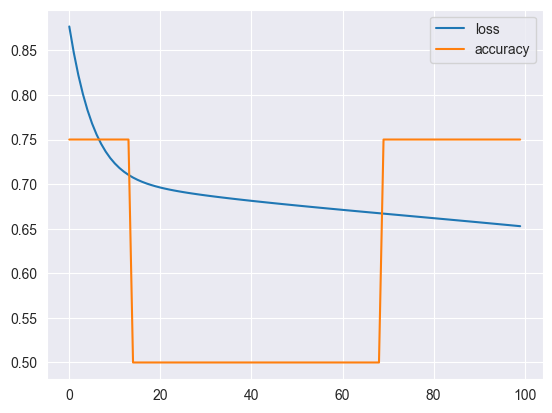

In [21]:
pd.DataFrame(hist.history).plot();

In [22]:
model_dir = Path("models/model_nn")
model_path = model_dir / "basic_model"
    
print(f"model_dir:\t{model_dir}")
print(f"model_path:\t{model_path}")

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_dir:	models/model_nn
model_path:	models/model_nn/basic_model


In [23]:
# Save model in older 'HDF5' format

# Returns a JSON string containing the network configuration.
model_structure = model.to_json()
with open(f"{model_dir}/basic_model.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{model_dir}/basic_weights.h5")
print('Model saved.')

Model saved.


In [24]:
# Save model in 'tf' format
model.save(f"{model_dir}/model_tf")

INFO:tensorflow:Assets written to: models/model_nn/model_tf/assets


In [25]:
!ls -l {model_dir}/model_tf

total 152
drwxr-xr-x  2 gb  staff     64 Mar 25 15:30 assets
-rw-r--r--  1 gb  staff   7646 Mar 29 22:06 keras_metadata.pb
-rw-r--r--  1 gb  staff  69078 Mar 29 22:06 saved_model.pb
drwxr-xr-x  4 gb  staff    128 Mar 29 22:06 variables


<a name='5.1.8'></a><a id='5.1.8'></a>
## 5.1.8 Onward and deepward
<a href="#top">[back to top]</a>

Problem: What are recent innovations in neural networks?

Idea: Different activation functions, dynamically ychanging the learning rate, dropout, regularization of weights

<a name='5.1.9'></a><a id='5.1.9'></a>
## 5.1.9 Normalization: Input with style
<a href="#top">[back to top]</a>

Problem: How can we keep the weights from growing too huge or too small?

Idea: Normalize the input data. Normalization also ensures that each neuron works within a similar range of input values as the other elments within a sample vector. The goal is to get the data in some range like [-1, 1] or [0, 1] for each element in each sample without losing information. 